/tmp/ipykernel_75826/2782324511.py:24: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = pd.to_datetime(data['id'], errors='ignore')
/tmp/ipykernel_75826/2782324511.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))


Model: "Bidirectional_LSTM_Seq2Seq_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 36, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 36, 128)   │     35,328 │ encoder_inputs[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm_0      │ (None, 36, 128)   │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128)       │          0 │ encoder_norm_0[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 6, 128)    │          0 │ get_item_1[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_0      │ (None, 6, 128)    │    131,584 │ repeat_vector_1[… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_norm_0      │ (None, 6, 128)    │        256 │ decoder_lstm_0[0… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 6, 128)    │          0 │ decoder_norm_0[0… │
│ (Attention)         │                   │            │ encoder_norm_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 6, 256)    │          0 │ decoder_norm_0[0… │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 6, 1)      │        257 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 6)         │          0 │ output_layer[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 167,681 (655.00 KB)

 Trainable params: 167,681 (655.00 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1730950347.698331   75914 cuda_dnn.cc:529] Loaded cuDNN version 90300


188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 1.5922 - mae: 0.5318 - val_loss: 0.4750 - val_mae: 0.2414 - learning_rate: 1.0000e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


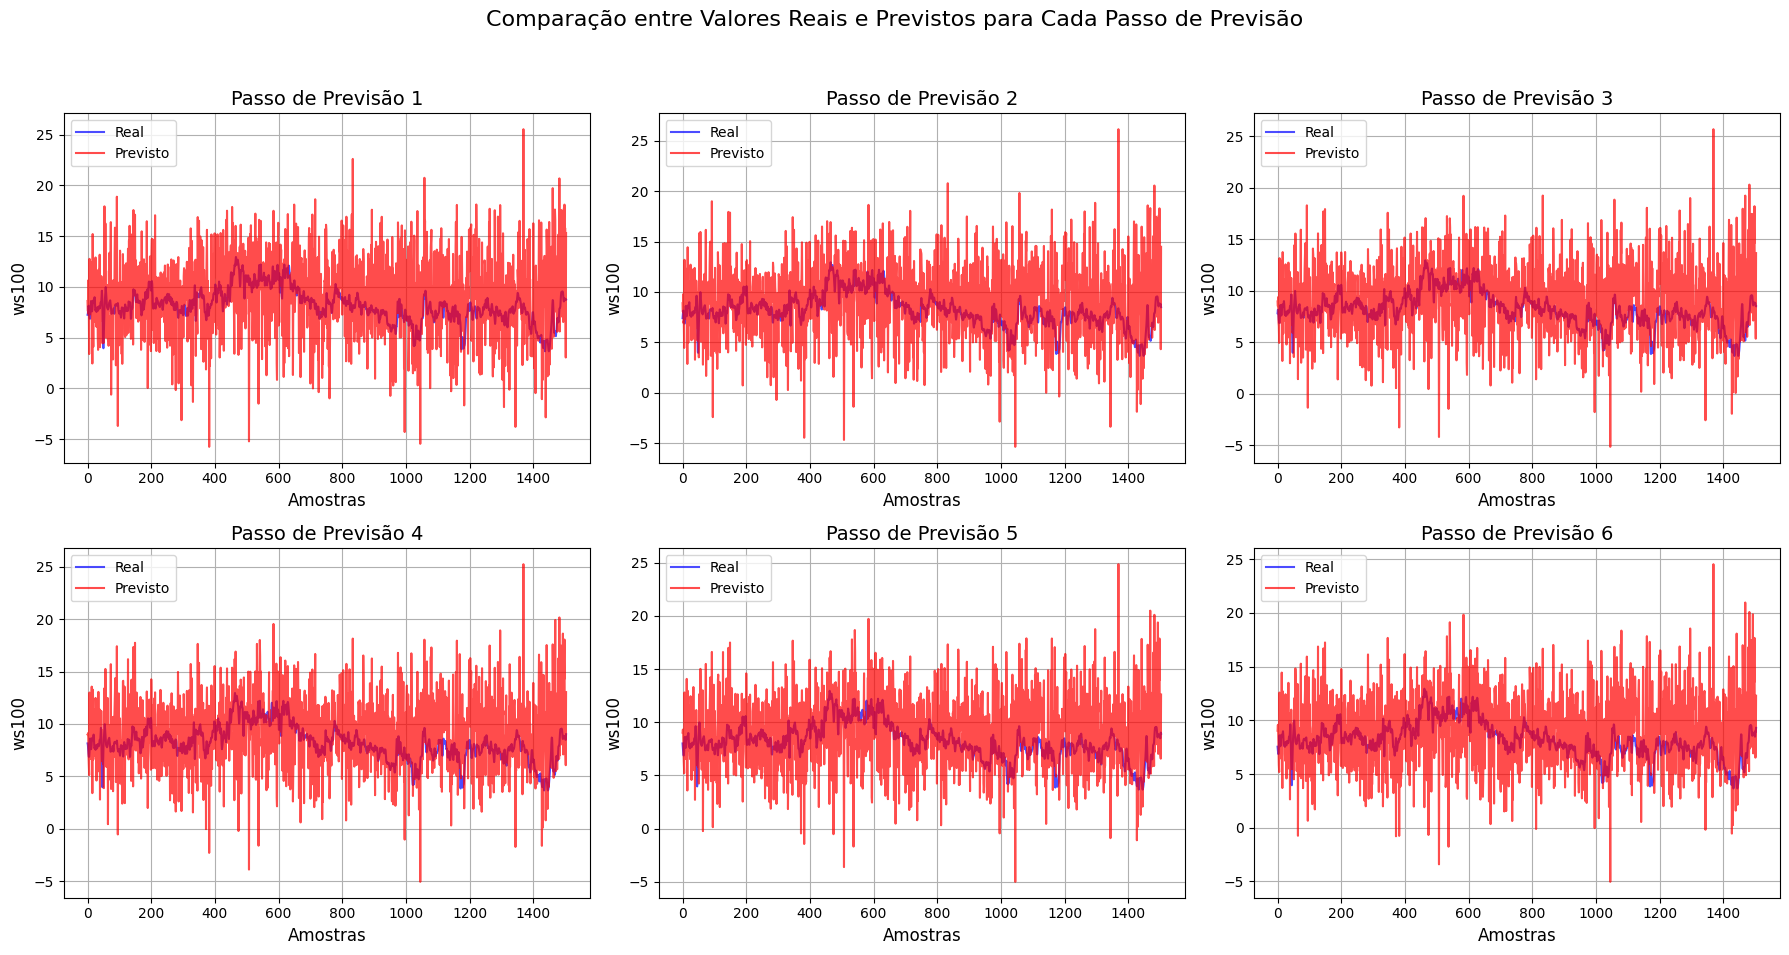

  Métrica      Valor
0     MAE   3.005407
1     MSE  14.925085
2    MAPE  39.545559


/tmp/ipykernel_75826/2782324511.py:243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Métrica', y='Valor', data=metrics, palette='viridis')


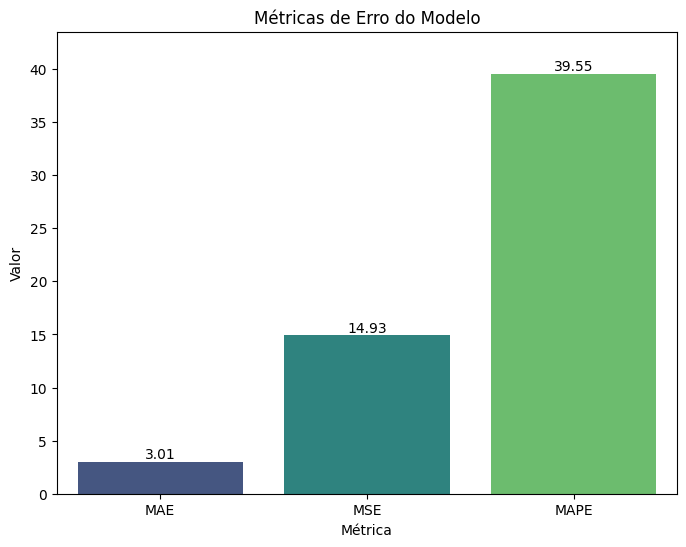

In [2]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (LSTM, GRU, Dense, Dropout, Bidirectional, 
                                     Conv1D, MaxPooling1D, Flatten, BatchNormalization,
                                     Input, RepeatVector, TimeDistributed, Concatenate, Attention, LayerNormalization, Lambda)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperParameters, Hyperband
import os
import seaborn as sns

# %%
# Carregar o dataset
data = pd.read_csv("dataset.csv")
data.index = pd.to_datetime(data['id'], errors='ignore')
data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))

# Inicializando variables como um DataFrame vazio
variables = pd.DataFrame(index=data.index)

# Aplicando o filtro Savitzky-Golay para suavizar as colunas
window_length = 17  # Deve ser ímpar e adequado ao tamanho dos seus dados
polyorder = 11

for col in ['ws100', 'humid', 'wdisp100', 'wdir100']:
    if col in data.columns:
        variables[f'{col}_savgol'] = savgol_filter(data[col], window_length=window_length, polyorder=polyorder)
    else:
        raise ValueError(f"A coluna {col} não existe no dataset.")

# Separar a coluna 'ws100_savgol' para um scaler separado
scaler_ws100 = MinMaxScaler()
variables_scaled_ws100 = scaler_ws100.fit_transform(variables[['ws100_savgol']])

# Escalar as demais variáveis
scaler_other = MinMaxScaler()
variables_scaled_other = scaler_other.fit_transform(variables.drop(columns=['ws100_savgol']))

# Combinar as variáveis escaladas
variables_scaled = np.hstack((variables_scaled_ws100, variables_scaled_other))
variables_scaled = pd.DataFrame(
    variables_scaled, 
    columns=variables.columns, 
    index=variables.index
)

# %%
input_steps = 36
output_steps = 6

# Criar sequências de treinamento
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps)])
        y.append(data[(i + input_steps):(i + input_steps + output_steps), 0])  # Previsão apenas do ws100_savgol
    return np.array(X), np.array(y)

# Transformar variables_scaled em array
data_array = variables_scaled.values  # Dados escalonados

# Criar as sequências para treino e teste
X, y = create_sequences(data_array, input_steps, output_steps)

# Dividir os dados em treinamento e teste (80% treino e 20% teste)
split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# %%
def custom_loss(y_true, y_pred):
    mu = tf.reduce_mean(y_true, axis=1, keepdims=True)
    sigma = tf.math.reduce_std(y_true, axis=1, keepdims=True)
    
    # Definir raridade como a distância absoluta em relação à média normalizada
    normalized_distance = tf.abs((y_true - mu) / sigma)
    
    # Definir o peso usando uma função que aumenta com a raridade
    weight = 1 + 2.0 * normalized_distance  # Ajuste o fator multiplicativo conforme necessário
    
    # Calcular a perda ponderada
    loss = tf.reduce_mean(weight * tf.square(y_true - y_pred))
    return loss

def build_model(input_steps, num_features, output_steps):
    num_layers = 1
    units = 64
    dropout_rate = 0.3
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    # Encoder
    encoder_inputs = Input(shape=(input_steps, num_features), name='encoder_inputs')
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        encoder_outputs = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        encoder_outputs = LayerNormalization(name=f'encoder_norm_{i}')(encoder_outputs)
    
    # Contexto de Atenção
    context_vector = encoder_outputs  # Saídas do encoder para a atenção
    
    # Decoder
    decoder_inputs = RepeatVector(output_steps)(encoder_outputs[:, -1, :])  # Usar o último passo do encoder
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_outputs = LSTM(
            units=units * 2,
            return_sequences=True,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_outputs = LayerNormalization(name=f'decoder_norm_{i}')(decoder_outputs)
    
    # Aplicar Atenção
    attention_output = Attention(name='attention_layer')([decoder_outputs, context_vector])
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    # Camada de Saída
    # Alteração: Usar TimeDistributed com Dense(1) e remover dimensões extras
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined_context)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(outputs)  # [batch, output_steps]
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_Seq2Seq_with_Attention')
    
    # Compilação do Modelo com a Função de Perda Customizada
    model.compile(
        optimizer=optimizer,
        loss=custom_loss,
        metrics=['mae']
    )
    
    return model

# %%
# Construir o modelo
num_features = X_train.shape[2]
model = build_model(input_steps, num_features, output_steps)

# Exibir o resumo do modelo
model.summary()

# %%
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

# Treinar o modelo
history = model.fit(
    X_train, y_train, 
    epochs=1,  # Aumentar o número de épocas conforme necessário
    batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# %%
# Carregar o melhor modelo salvo
model.load_weights('best_model.h5.keras')

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Inverter a escala para os valores previstos e reais
# Como o scaler_ws100 foi ajustado em uma coluna, precisamos adaptar a forma para inversão
y_test_inversed = scaler_ws100.inverse_transform(y_test)
y_pred_inversed = scaler_ws100.inverse_transform(y_pred)

# %%
# Visualização das Previsões

# Número de passos de previsão
output_steps = 6

# Criar uma figura com subplots 2x3
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparação entre Valores Reais e Previstos para Cada Passo de Previsão', fontsize=16)

for step in range(output_steps):
    row = step // 3
    col = step % 3
    ax = axes[row, col]
    
    # Extrair os valores reais e previstos para o passo atual
    real = y_test_inversed[:, step]
    pred = y_pred_inversed[:, step]
    
    # Plotar os valores reais e previstos
    ax.plot(real, label='Real', color='blue', alpha=0.7)
    ax.plot(pred, label='Previsto', color='red', alpha=0.7)
    
    # Adicionar título e legendas
    ax.set_title(f'Passo de Previsão {step + 1}', fontsize=14)
    ax.set_xlabel('Amostras', fontsize=12)
    ax.set_ylabel('ws100', fontsize=12)
    ax.legend()
    ax.grid(True)
    
    # Opcional: Adicionar a diferença (resíduo) como uma linha pontilhada
    # ax.plot(real - pred, label='Resíduo', color='green', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar o layout para não sobrepor o título
plt.show()

# %%
# Visualização das Métricas de Erro

# Calcular métricas
mae = mean_absolute_error(y_test_inversed, y_pred_inversed)
mse = mean_squared_error(y_test_inversed, y_pred_inversed)
mape = mean_absolute_percentage_error(y_test_inversed, y_pred_inversed) * 100  # em porcentagem

# Exibir as métricas
metrics = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'MAPE'],
    'Valor': [mae, mse, mape]
})

print(metrics)

# Plotar as métricas em um gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Métrica', y='Valor', data=metrics, palette='viridis')
plt.title('Métricas de Erro do Modelo')
for index, row in metrics.iterrows():
    plt.text(index, row.Valor, f"{row.Valor:.2f}", color='black', ha="center", va="bottom")
plt.ylabel('Valor')
plt.ylim(0, max(metrics['Valor']) * 1.1)
plt.show()
